In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize

In [2]:
c = 2.99792458e+5
omega_v0 = 0.0014
omega_bh2 = 0.02305

In [35]:
def E(z, parameters):   
    omega_m0,omega_k0,wX,h0 = parameters
    h=h0/100
    omega_cb0 = omega_m0 - omega_v0
    #omega=(omega_bh2+omega_ch2+omega_vh2)/h**2
    return ((omega_m0*((1+z)**3)) + omega_k0*(1+z)**2 + (1 - omega_m0 - omega_k0)*(1+z)**(3*(1+wX)))**(1/2)
def f(z,parameters):
    return 1/E(z,parameters)

In [54]:
def Chi_sq1(parameters,H_obs,z_obs,sigma_obs):
    n = z_obs.shape[0]
    H_theo = np.zeros(n)
    omega_m0,omega_k0,wX,Ho = parameters
    chi_sq=0
    for i in range(n):
        H_theo[i]= Ho*(E(z_obs[i],parameters))
        chi_sq= chi_sq+(H_obs[i]-H_theo[i])**2/(sigma_obs[i])**2
    return chi_sq

In [52]:
def dH(parameters,z):
    omega_m0,omega_k0,wX,Ho = parameters
    return c/(Ho*E(z,parameters))
def dC(parameters,z):
    omega_m0,omega_k0,wX,Ho = parameters
    return (c/Ho)*integrate.quad(f,0,(z),args=(parameters,))[0]
def dM(parameters,z):
    omega_m0,omega_k0,wX,Ho = parameters
    if omega_k0 == 0:
        return dC(parameters,z)
    elif omega_k0 > 0:
        return (c / (Ho*np.sqrt(omega_k0)))*np.sinh(np.sqrt(omega_k0)*Ho*dC(parameters,z) / c)
    elif omega_k0 < 0:
        mod_omega_k0 = -omega_k0
        return (c / (Ho*np.sqrt(mod_omega_k0)))*np.sin(np.sqrt(mod_omega_k0)*Ho*dC(parameters,z) / c)
def dA(parameters,z):
    return dM(parameters,z)/(1+z)
def dV(parameters,z):
    Ho = parameters[3]
    return (((c/Ho)*((dM(parameters,z))**2)*(z/E(z,parameters)))**(1/3))

In [50]:
def rs(parameters,z):
    omega_m0,omega_k0,wX,Ho = parameters
    h = Ho/100
    num =np.exp(-72.3*(omega_v0*h**2+0.0006)**2)
    den = ((omega_bh2)**(0.12807))*(((omega_m0 - omega_v0)*h**2)**(0.25351))
    return 55.154*num/den

In [39]:
def Chi_sq2(parameters,D_obs,z_obs,cov_mat):
    datapoints= z_obs.shape
    D_theo= np.zeros(datapoints)
    Ho=parameters[3]
    
    dm_indices= [0,2,4]
    h_indices=[3,1,5]
    Dv_indices = [6,8]
    dA_indices = [7]
    dhrs_indices = [9]
    dmrs_indices = [10]
    
    rs_fid= 147.78
    
    for i in Dv_indices:
        if i==6:
            D_theo[i]= dV(parameters,z_obs[i])*147.5/rs(parameters,z_obs[i])
        else:
            D_theo[i]= dV(parameters,z_obs[i])*rs_fid/rs(parameters,z_obs[i])
    for i in h_indices:
        D_theo[i]=Ho*E(z_obs[i],parameters)*rs(parameters,z_obs[i])/rs_fid
    for i in dm_indices:
        D_theo[i]=dM(parameters,z_obs[i])*rs_fid/rs(parameters,z_obs[i])
    for i in dhrs_indices:
        D_theo[i]=(dH(parameters,z_obs[i]))/ rs(parameters,z_obs[i])
    for i in dmrs_indices:
        D_theo[i]=(dM(parameters,z_obs[i]))/ rs(parameters,z_obs[i])
    for i in dA_indices:
        D_theo[i]=(dA(parameters,z_obs[i]))/rs(parameters,z_obs[i])
    #print(parameters)
    #print("D_theo1",D_theo)
    #print("D_obs",D_obs)
    D_theo= D_theo-D_obs
    #print("D_theo",D_theo)
    A = np.matmul(np.linalg.inv(cov_mat),D_theo)
    #print("A",A)
    final = (np.matmul(D_theo.T,A))
    #print(final)
    #print(np.linalg.inv(cov_mat))
    #print(final)
    return final[0,0]

In [40]:
def Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs2,cov_matrix):
    #print(Chi_sq3(parameters,H_obs1,z_obs1,sigma_obs1))
    return (Chi_sq2(parameters,D_obs,z_obs2,cov_matrix)+ Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1))

In [116]:
def lnprior1(parameters):
    omega_m0,omega_k0,wX,Ho = parameters
    omega_lambda = 1-omega_k0 - omega_m0
    if 0.1<=omega_m0<=0.7 and 50<=Ho<=85 and -2<=wX<=0 and -0.7<=omega_k0<=0.7:
        return 0
    return -np.inf

In [117]:
def log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    return -Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)/2

In [118]:
def log_probability(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    lp = lnprior1(parameters)
    if not np.isfinite(lp):
        return -np.inf
    #print(lp)
    #print(lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix))
    return lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)

In [119]:
Data = pd.read_csv("H(z) data - Sheet1.csv")
z_obs1 = Data['z']
z_obs1 = z_obs1.to_numpy()
z_obs1 = np.reshape(z_obs1,(31,1))
H_obs1 = Data['H(z)']
sigma_obs1 = Data['sigma']
print(Data)
print(z_obs1.shape)

         z   H(z)  sigma
0   0.0700   69.0   19.6
1   0.0900   69.0   12.0
2   0.1200   68.6   26.2
3   0.1700   83.0    8.0
4   0.1790   75.0    4.0
5   0.1990   75.0    5.0
6   0.2000   72.9   29.6
7   0.2700   77.0   14.0
8   0.2800   88.8   36.6
9   0.3520   83.0   14.0
10  0.3802   83.0   13.5
11  0.4000   95.0   17.0
12  0.4004   77.0   10.2
13  0.4247   87.1   11.2
14  0.4497   92.8   12.9
15  0.4700   89.0   50.0
16  0.4783   80.9    9.0
17  0.4800   97.0   62.0
18  0.5930  104.0   13.0
19  0.6800   92.0    8.0
20  0.7810  105.0   12.0
21  0.8750  125.0   17.0
22  0.8800   90.0   40.0
23  0.9000  117.0   23.0
24  1.0370  154.0   20.0
25  1.3000  168.0   17.0
26  1.3630  160.0   33.6
27  1.4300  177.0   18.0
28  1.5300  140.0   14.0
29  1.7500  202.0   40.0
30  1.9650  186.5   50.4
(31, 1)


In [120]:
Data = pd.read_csv("BAO data - Sheet1 (3).csv")
print(Data)
Data['value'][9] = 8.86
Data['value'][10] = 37.41
Data['z'][9] = 2.34
Data['z'][10] = 2.34
#print(Data)

        z      value   sigma
0   0.380  1512.3900     NaN
1   0.380    81.2087     NaN
2   0.510  1975.2200     NaN
3   0.510    90.9029     NaN
4   0.610  2306.6800     NaN
5   0.610    98.9647     NaN
6   0.122   539.0000   17.00
7   0.810    10.7500    0.43
8   1.520  3843.0000  147.00
9   2.334    37.5000     NaN
10  2.334     8.9900     NaN


In [121]:
z_obs = (Data['z'].to_numpy()).astype(float)
z_obs = np.reshape(z_obs, (11,1))
Data = Data.to_numpy()
D_obs = Data[:,1].astype(float)
D_obs = np.reshape(D_obs,(11,1))
print(z_obs.shape)
print(D_obs)

(11, 1)
[[1512.39  ]
 [  81.2087]
 [1975.22  ]
 [  90.9029]
 [2306.68  ]
 [  98.9647]
 [ 539.    ]
 [  10.75  ]
 [3843.    ]
 [   8.86  ]
 [  37.41  ]]


In [122]:
cov_matrix2 = np.matrix([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778,0,0,0,0,0],
                    [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056,0,0,0,0,0],
                    [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013,0,0,0,0,0],
                    [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334,0,0,0,0,0],
                    [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327,0,0,0,0,0],
                    [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936,0,0,0,0,0],
                    [0,0,0,0,0,0,17**2,0,0,0,0],
                     [0,0,0,0,0,0,0,0.43**2,0,0,0],
                     [0,0,0,0,0,0,0,0,147**2,0,0],
                     [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                     [0,0,0,0,0,0,0,0,0,-0.183396,3.4596]])

In [154]:
initial = np.array([0.3,0.1,-0.1,70]) 
soln = minimize(Chi_sq, initial, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2),bounds=[(-1,1),(-1,1),(-np.inf,np.inf),(0,np.inf)])
print(soln)

      fun: 18.425155409660576
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.29318778e-04, 1.64845915e-04, 3.34665627e-04, 1.70530364e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 205
      nit: 36
     njev: 41
   status: 0
  success: True
        x: array([ 0.32725786, -0.15851421, -0.73033872, 65.9740951 ])


In [79]:
import emcee
pos = soln.x + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

#filename = "BAO_LCDM.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2))

sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:11:16<00:00,  2.34it/s]


In [125]:
import emcee
p0 = soln.x + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2))

In [126]:
pos, prob, state = sampler.run_mcmc(p0, 2000,progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [40:50<00:00,  1.23s/it]


In [127]:
sampler.reset()

In [ ]:
sampler.run_mcmc(pos, 20000, progress=True)
##Sampler runs for a total of 20000 steps.


 99%|█████████████████████████████████████████████████████████████████████████▌| 19898/20000 [3:29:44<02:39,  1.56s/it]

In [ ]:
chain = sampler.flatchain.copy()

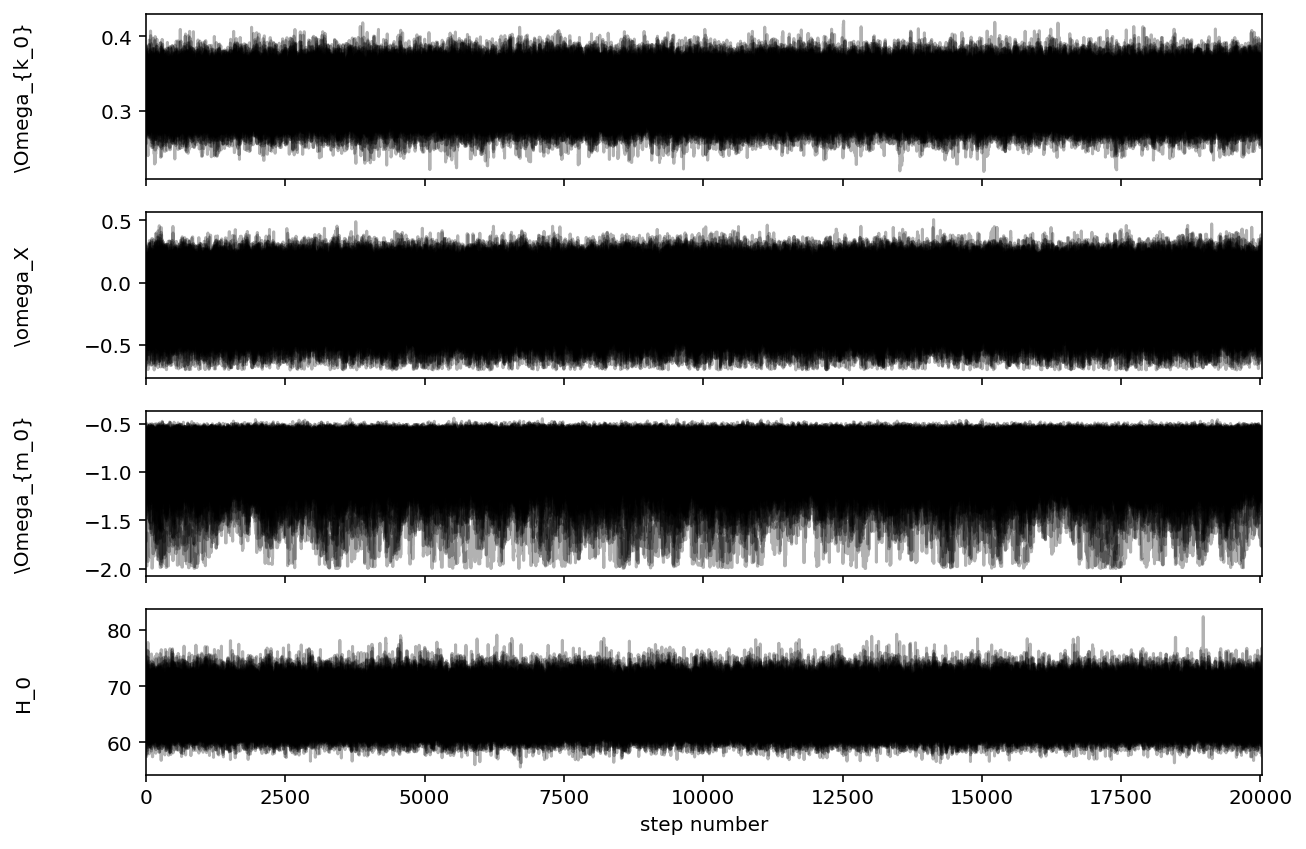

In [144]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["\Omega_{k_0}","\omega_X","\Omega_{m_0}", "H_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [145]:
tau = sampler.get_autocorr_time()
print(tau)

[ 97.13824617 124.12471886 166.69033192  62.8734731 ]


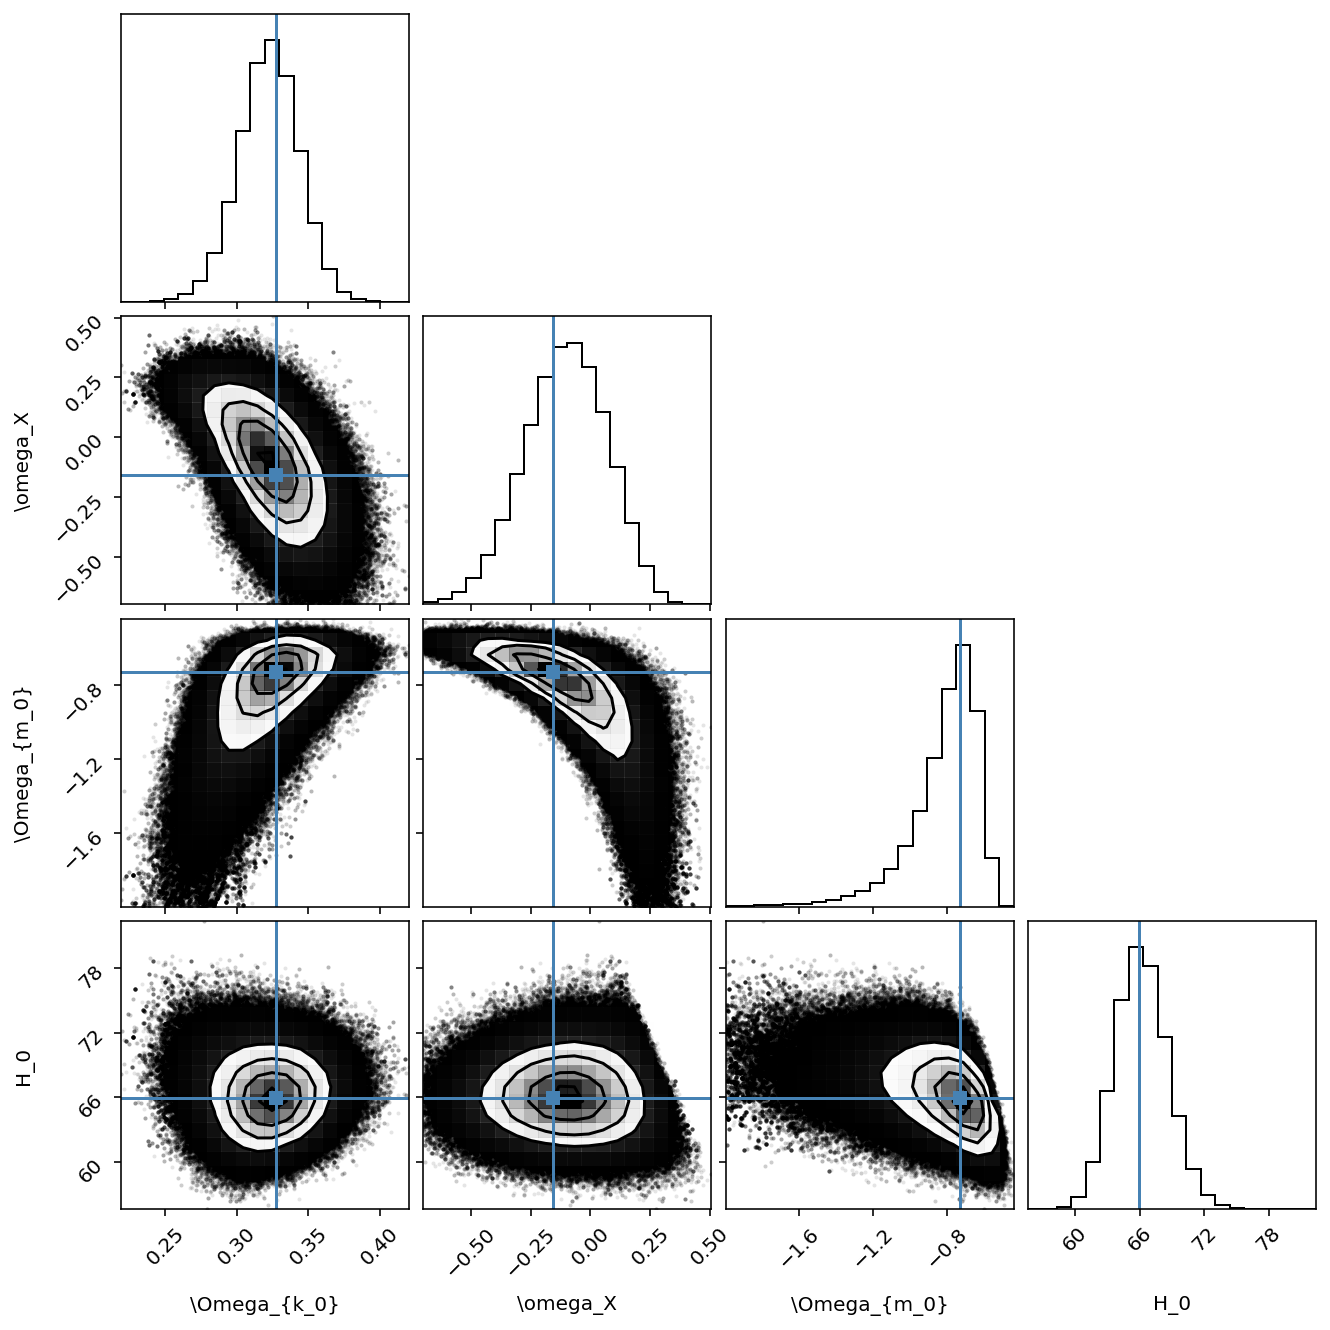

In [146]:
flat_samples = sampler.get_chain(flat=True)
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=soln.x
);

In [147]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.4.3, Matplotlib version: 3.5.2


In [148]:
names = ["omega_m02","omega_k0","wX","Ho"]
labels =  ["\Omega_{m_0}","\Omega_{k_0}","\omega_X", "H_0"]
samples2 = MCSamples(samples=flat_samples,names = names, labels = labels)

Removed no burn in


In [149]:
means = samples2.getMeans()
stats = samples2.getMargeStats()
conf_levels = samples2.contours
lims0 = stats.parWithName('omega_m02').limits
lims1 = stats.parWithName('omega_k0').limits
lims2 = stats.parWithName('wX').limits
lims3 = stats.parWithName('Ho').limits

In [150]:
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})

<Figure size 432x324 with 0 Axes>

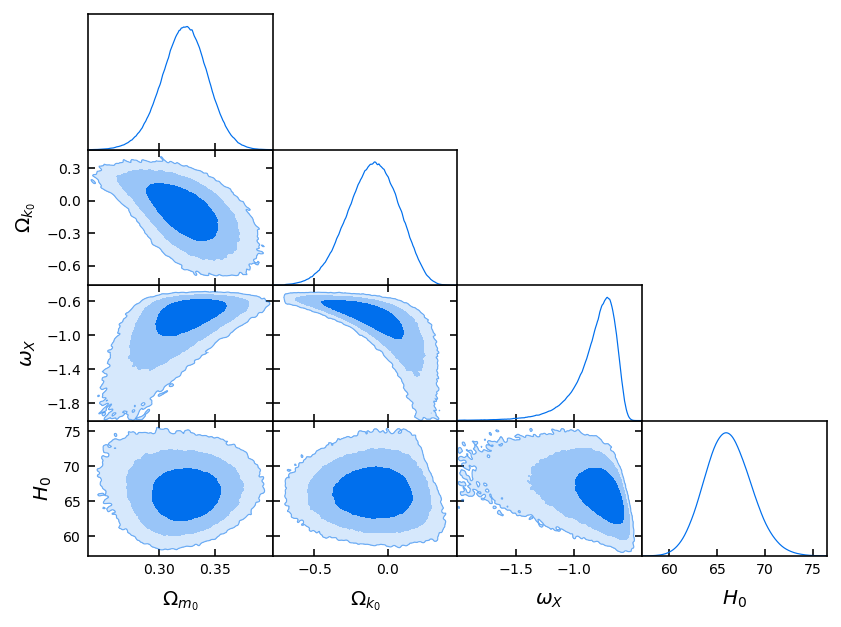

In [151]:
g = plots.get_single_plotter()

g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);

In [152]:
for conf, lim0, lim1, lim2, lim3 in zip(samples2.contours,lims0,lims1,lims2,lims3):
        if conf!=0.6827:
            continue
        print('\Omega_{m_0}, value: %.3f, lower: %.3f, upper: %.3f'%(means[0], lim0.lower - means[0], lim0.upper- means[0]))
        print('\Omega_{k_0}, value: %.3f, lower: %.3f, upper: %.3f'%(means[1], lim1.lower - means[1], lim1.upper- means[1]))
        print('\omega_X, value: %.3f, lower: %.3f, upper: %.3f'%(means[2], lim2.lower - means[2], lim2.upper - means[2]))
        print('H_0, value: %.2f, lower: %.2f, upper: %.2f'%(means[3], lim3.lower - means[3], lim3.upper - means[3]))

\Omega_{m_0}, value: 0.323, lower: -0.020, upper: 0.021
\Omega_{k_0}, value: -0.105, lower: -0.159, upper: 0.188
\omega_X, value: -0.817, lower: -0.069, upper: 0.214
H_0, value: 66.19, lower: -2.55, upper: 2.28


In [156]:
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin,thin= thin, flat=True)
labels = ["alpha", "omega_bh2", "omega_ch2", "Ho"]
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

[ 97.13824617 124.12471886 166.69033192  62.8734731 ]
burn-in: 333
thin: 31
flat chain shape: (127000, 4)


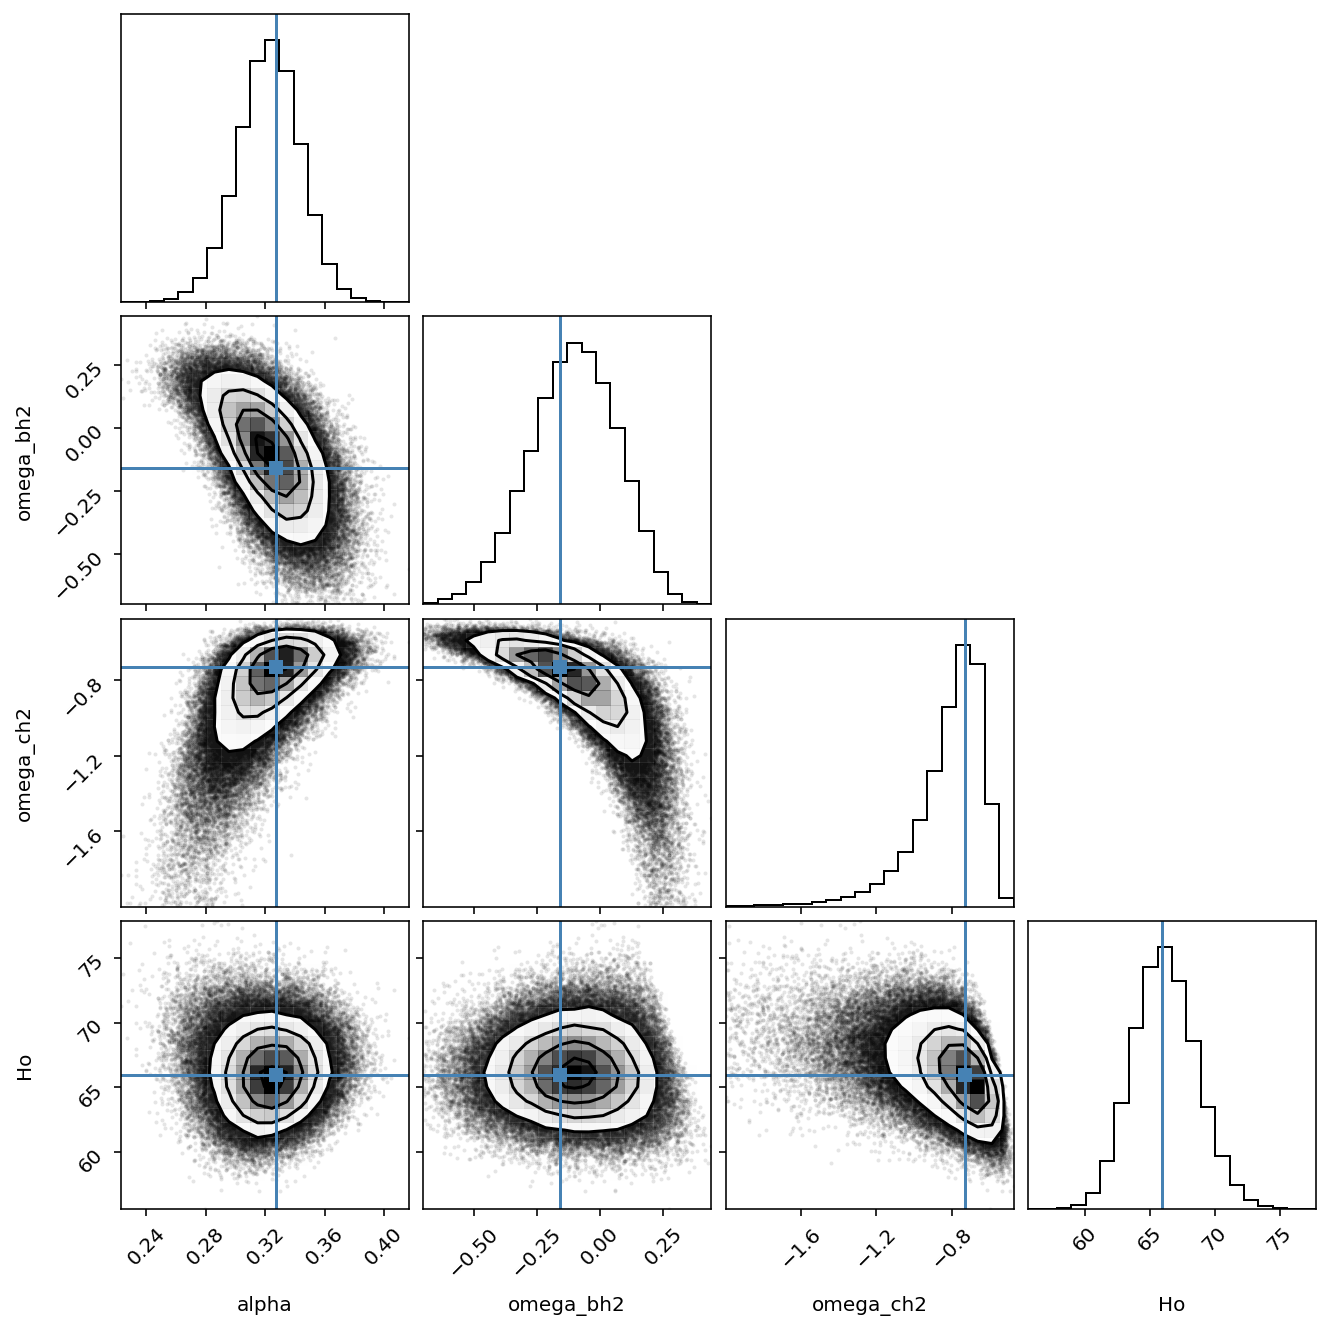

In [157]:
fig = corner.corner(
    flat_samples, labels=labels, truths=soln.x
);

In [158]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.4.3, Matplotlib version: 3.5.2


In [159]:
names = ["omega_m02","omega_k0","wX","Ho"]
labels =  ["\Omega_{m_0}","\Omega_{k_0}","\omega_X", "H_0"]
samples2 = MCSamples(samples=flat_samples,names = names, labels = labels)

Removed no burn in


<Figure size 432x324 with 0 Axes>

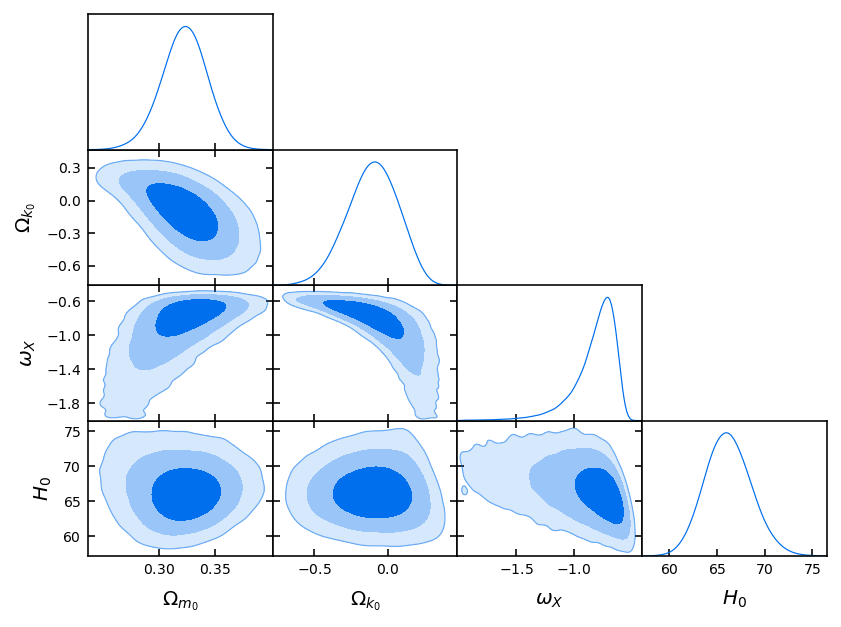

In [161]:
g = plots.get_single_plotter()
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})
g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);

In [162]:
for conf, lim0, lim1, lim2, lim3 in zip(samples2.contours,lims0,lims1,lims2,lims3):
        if conf!=0.6827:
            continue
        print('\Omega_{m_0}, value: %.3f, lower: %.3f, upper: %.3f'%(means[0], lim0.lower - means[0], lim0.upper- means[0]))
        print('\Omega_{k_0}, value: %.3f, lower: %.3f, upper: %.3f'%(means[1], lim1.lower - means[1], lim1.upper- means[1]))
        print('\omega_X, value: %.3f, lower: %.3f, upper: %.3f'%(means[2], lim2.lower - means[2], lim2.upper - means[2]))
        print('H_0, value: %.2f, lower: %.2f, upper: %.2f'%(means[3], lim3.lower - means[3], lim3.upper - means[3]))

\Omega_{m_0}, value: 0.323, lower: -0.020, upper: 0.021
\Omega_{k_0}, value: -0.105, lower: -0.159, upper: 0.188
\omega_X, value: -0.817, lower: -0.069, upper: 0.214
H_0, value: 66.19, lower: -2.55, upper: 2.28
